# Import

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

# 0. 기본 설정 및 메모리 관리 함수

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def clear_memory():
    """메모리 정리 유틸리티"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Using device: cuda


# 1. 모델 아키텍처

In [40]:
class S1EmbeddingLayerWithFeatureEncoding(nn.Module):
    def __init__(self, n_features, embedding_dim, feature_names=None):
        super().__init__()
        self.n_features, self.embedding_dim = n_features, embedding_dim
        self.feature_projections = nn.ModuleList([
            nn.Sequential(nn.Linear(1, embedding_dim), nn.LayerNorm(embedding_dim), nn.ReLU(), nn.Dropout(0.1))
            for _ in range(n_features)
        ])
        self.feature_type_embedding = nn.Embedding(n_features, embedding_dim)
        self.feature_names = feature_names or [f"feature_{i}" for i in range(n_features)]
        self.alpha = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        batch_size = x.shape[0]
        embedded_features = []
        for i in range(self.n_features):
            projected = self.feature_projections[i](x[:, i:i+1])
            feature_type = self.feature_type_embedding.weight[i:i+1].expand(batch_size, -1)
            combined = self.alpha * projected + (1 - self.alpha) * feature_type
            embedded_features.append(combined)
        return torch.stack(embedded_features, dim=1)

class OptimizedCoAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.W = nn.Parameter(torch.randn(d_model, d_model))
        nn.init.xavier_uniform_(self.W)

    def forward(self, s1_seq, s2_seq, s2_mask=None):
        affinity = torch.matmul(torch.matmul(s1_seq, self.W), s2_seq.transpose(-2, -1))
        if s2_mask is not None:
            # 텐서의 데이터 타입에 맞는 최소값으로 채우도록 수정
            fill_value = torch.finfo(affinity.dtype).min
            affinity = affinity.masked_fill(s2_mask.unsqueeze(1) == 0, fill_value)

        s1_to_s2_weights = F.softmax(affinity, dim=-1)
        s1_context = torch.matmul(s1_to_s2_weights, s2_seq)

        s2_to_s1_weights = F.softmax(affinity.transpose(-2, -1), dim=-1)
        s2_context = torch.matmul(s2_to_s1_weights, s1_seq)

        return s1_context, s2_context

class RegressionHead(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # 여러 레이어를 거쳐 최종적으로 1개의 값을 출력
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 1) # 최종 출력 차원을 1로 설정
        )

    def forward(self, x):
        return self.network(x)

# --- 어텐션 모듈 (3가지) ---
class CoAttention(nn.Module):
    """양방향(S1 <-> S2) 어텐션"""
    def __init__(self, d_model):
        super().__init__()
        self.W = nn.Parameter(torch.randn(d_model, d_model))
        nn.init.xavier_uniform_(self.W)

    def forward(self, s1_seq, s2_seq, s2_mask=None):
        affinity = torch.matmul(torch.matmul(s1_seq, self.W), s2_seq.transpose(-2, -1))
        if s2_mask is not None:
            affinity = affinity.masked_fill(s2_mask.unsqueeze(1) == 0, torch.finfo(affinity.dtype).min)

        s1_to_s2_weights = F.softmax(affinity, dim=-1)
        s1_context = torch.matmul(s1_to_s2_weights, s2_seq)

        s2_to_s1_weights = F.softmax(affinity.transpose(-2, -1), dim=-1)
        s2_context = torch.matmul(s2_to_s1_weights, s1_seq)
        return s1_context, s2_context

class UnidirectionalAttention_S1_to_S2(nn.Module):
    """단방향(S1 -> S2) 어텐션"""
    def __init__(self, d_model):
        super().__init__()
        self.W = nn.Parameter(torch.randn(d_model, d_model))
        nn.init.xavier_uniform_(self.W)

    def forward(self, s1_seq, s2_seq, s2_mask=None):
        affinity = torch.matmul(torch.matmul(s1_seq, self.W), s2_seq.transpose(-2, -1))
        if s2_mask is not None:
            affinity = affinity.masked_fill(s2_mask.unsqueeze(1) == 0, torch.finfo(affinity.dtype).min)
        s1_to_s2_weights = F.softmax(affinity, dim=-1)
        s1_context = torch.matmul(s1_to_s2_weights, s2_seq)
        return s1_context, s2_seq # s2는 원본 그대로 반환

class UnidirectionalAttention_S2_to_S1(nn.Module):
    """단방향(S2 -> S1) 어텐션"""
    def __init__(self, d_model):
        super().__init__()
        self.W = nn.Parameter(torch.randn(d_model, d_model))
        nn.init.xavier_uniform_(self.W)

    def forward(self, s1_seq, s2_seq, s2_mask=None):
        affinity = torch.matmul(torch.matmul(s1_seq, self.W), s2_seq.transpose(-2, -1))
        s2_to_s1_weights = F.softmax(affinity.transpose(-2, -1), dim=-1)
        s2_context = torch.matmul(s2_to_s1_weights, s1_seq)
        return s1_seq, s2_context # s1은 원본 그대로 반환

# --- 어텐션 모듈을 주입받는 모델 ---
class AttentionModel(nn.Module):
    """어텐션 모듈을 선택적으로 사용하는 범용 모델"""
    def __init__(self, n_s1_features, embedding_dim, attention_module, feature_names=None):
        super().__init__()
        self.s1_embedding = S1EmbeddingLayerWithFeatureEncoding(n_s1_features, embedding_dim, feature_names)
        self.attention = attention_module
        self.batch_norm = nn.BatchNorm1d(embedding_dim * 2)
        self.prediction_head = RegressionHead(embedding_dim * 2)

    def forward(self, s1, s2, s2_mask):
        s1_embedded = self.s1_embedding(s1)
        s1_context, s2_context = self.attention(s1_embedded, s2, s2_mask)

        s1_pooled = s1_context.mean(dim=1)

        s2_mask_expanded = s2_mask.unsqueeze(-1).float()
        s2_sum = (s2_context * s2_mask_expanded).sum(dim=1)
        s2_count = s2_mask_expanded.sum(dim=1).clamp(min=1e-9)
        s2_pooled = s2_sum / s2_count

        combined = self.batch_norm(torch.cat([s1_pooled, s2_pooled], dim=-1))
        return self.prediction_head(combined)

# --- self attention 모델 ---
class S1_SelfAttention_Model(nn.Module):
    """오직 S1(정형 데이터)만 사용하여 예측하는 모델"""
    def __init__(self, n_s1_features, embedding_dim, n_transformer_layers=2, n_heads=4, feature_names=None):
        super().__init__()
        self.s1_embedding = S1EmbeddingLayerWithFeatureEncoding(n_s1_features, embedding_dim, feature_names)

        # S1 피처 시퀀스 내부의 관계를 학습할 Transformer 인코더
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=n_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_transformer_layers)

        # 최종 예측 헤드 (입력 차원이 embedding_dim 하나임)
        self.prediction_head = RegressionHead(embedding_dim)

    def forward(self, s1, s2, s2_mask): # s2, s2_mask는 입력으로 받지만 사용하지 않음
        # S1 임베딩
        s1_embedded = self.s1_embedding(s1)

        # S1 피처 간 셀프 어텐션 수행
        s1_context = self.transformer_encoder(s1_embedded)

        # 풀링하여 하나의 벡터로 요약
        s1_pooled = s1_context.mean(dim=1)

        # 최종 예측
        return self.prediction_head(s1_pooled)

class S2_SelfAttention_Model(nn.Module):
    """오직 S2(텍스트 데이터)만 사용하여 예측하는 모델"""
    def __init__(self, embedding_dim, n_transformer_layers=2, n_heads=8):
        super().__init__()
        # S2 토큰 시퀀스 내부의 관계를 추가로 학습할 Transformer 인코더
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=n_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_transformer_layers)

        # 최종 예측 헤드 (입력 차원이 embedding_dim 하나임)
        self.prediction_head = RegressionHead(embedding_dim)

    def forward(self, s1, s2, s2_mask): # s1은 입력으로 받지만 사용하지 않음
        # Transformer 인코더는 패딩 마스크를 사용
        transformer_mask = (s2_mask == 0)
        transformer_output = self.transformer_encoder(s2, src_key_padding_mask=transformer_mask)

        # [CLS] 토큰의 최종 출력 벡터를 문장 전체의 요약 정보로 사용
        s2_pooled = transformer_output[:, 0, :]

        # 최종 예측
        return self.prediction_head(s2_pooled)

# 2. 데이터 처리 클래스 (Streaming & Caching)

In [41]:
class TextEmbedder:
    def __init__(self, model_name='bert-base-uncased', max_length=128, cache_size=5000):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.model.eval()
        self.max_length = max_length
        self.cache = {}
        self.cache_order = []
        self.cache_size = cache_size

    def get_batch_embeddings(self, texts, batch_size=16):
        results = [None] * len(texts)
        new_indices, new_texts = [], []

        for i, text in enumerate(texts):
            text_hash = hash(text)
            if text_hash in self.cache:
                results[i] = self.cache[text_hash]
            else:
                new_indices.append(i)
                new_texts.append(text)

        if new_texts:
            with torch.no_grad():
                for i in range(0, len(new_texts), batch_size):
                    batch_texts = new_texts[i:i+batch_size]
                    indices_to_update = new_indices[i:i+batch_size]

                    encoded = self.tokenizer(
                        batch_texts, padding='max_length', truncation=True,
                        max_length=self.max_length, return_tensors='pt'
                    )
                    outputs = self.model(
                        input_ids=encoded['input_ids'].to(device),
                        attention_mask=encoded['attention_mask'].to(device)
                    )

                    batch_embeddings = outputs.last_hidden_state.cpu()
                    batch_masks = encoded['attention_mask'].cpu()

                    for j in range(len(batch_texts)):
                        emb, mask = batch_embeddings[j], batch_masks[j]
                        results[indices_to_update[j]] = (emb, mask)

                        text_hash = hash(batch_texts[j])
                        if len(self.cache) >= self.cache_size:
                            del self.cache[self.cache_order.pop(0)]
                        self.cache[text_hash] = (emb, mask)
                        self.cache_order.append(text_hash)

        embeddings, masks = zip(*results)
        return torch.stack(embeddings), torch.stack(masks)

class SimpleDataset(Dataset):
    """로그 변환 타겟과 원본 타겟을 모두 담는 데이터셋"""
    def __init__(self, features, texts, log_targets, original_targets):
        self.features = features
        self.texts = texts
        self.log_targets = log_targets
        self.original_targets = original_targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            's1': torch.FloatTensor(self.features[idx]),
            'text': self.texts[idx],
            'log_target': torch.FloatTensor([self.log_targets[idx]]),
            'original_target': torch.FloatTensor([self.original_targets[idx]])
        }


# 3. 메인 학습 파이프라인 및 종속변수 시각화 코드


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
import torch

def visualize_results(model, test_loader, device):
    """
    최종 모델의 예측 결과를 산점도와 히스토그램으로 시각화합니다.
    (로그 스케일 & 원본 스케일)
    """
    model.eval()
    all_preds_orig, all_targets_orig = [], []
    all_preds_log, all_targets_log = [], []

    print("\n" + "="*60 + "\n7. 결과 시각화 데이터 생성 중...\n" + "="*60)
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating data for visualization"):
            with torch.amp.autocast(device_type="cuda"): # 사용자 환경에 맞춰 그대로 둠
                log_preds = model(batch['s1'], batch['s2'], batch['s2_mask'])
                original_scale_preds = torch.expm1(log_preds)

                all_preds_orig.append(original_scale_preds.cpu().numpy())
                all_targets_orig.append(batch['original_target'].cpu().numpy())
                all_preds_log.append(log_preds.cpu().numpy())
                all_targets_log.append(batch['log_target'].cpu().numpy())

    preds_orig = np.concatenate(all_preds_orig).flatten()
    targets_orig = np.concatenate(all_targets_orig).flatten()
    preds_log = np.concatenate(all_preds_log).flatten()
    targets_log = np.concatenate(all_targets_log).flatten()

    fig, axes = plt.subplots(2, 2, figsize=(20, 18))
    sns.set_style("whitegrid")
    fig.suptitle('Model Prediction Analysis', fontsize=24)

    # --- 1. [0, 0] 로그 스케일 산점도 ---
    sns.scatterplot(x=targets_log, y=preds_log, alpha=0.5, ax=axes[0, 0])
    p1_log = max(targets_log.min(), preds_log.min())
    p2_log = min(targets_log.max(), preds_log.max())
    axes[0, 0].plot([p1_log, p2_log], [p1_log, p2_log], 'r--')
    axes[0, 0].set_title('Scatter Plot (Log Scale)', fontsize=16)
    axes[0, 0].set_xlabel('True Values (Log)', fontsize=12)
    axes[0, 0].set_ylabel('Predicted Values (Log)', fontsize=12)

    # --- 2. [0, 1] 원본 스케일 산점도 ---
    sns.scatterplot(x=targets_orig, y=preds_orig, alpha=0.5, ax=axes[0, 1])
    p1_orig = max(targets_orig.min(), preds_orig.min())
    p2_orig = min(targets_orig.max(), preds_orig.max())
    axes[0, 1].plot([p1_orig, p2_orig], [p1_orig, p2_orig], 'r--')
    axes[0, 1].set_title('Scatter Plot (Original Scale)', fontsize=16)
    axes[0, 1].set_xlabel('True Values', fontsize=12)
    axes[0, 1].set_ylabel('Predicted Values', fontsize=12)
    xlim_orig = np.percentile(targets_orig, 99)
    ylim_orig = np.percentile(preds_orig, 99)
    axes[0, 1].set_xlim(0, xlim_orig)
    axes[0, 1].set_ylim(0, ylim_orig)

    # --- 3. [1, 0] 로그 스케일 예측값 히스토그램 ---
    sns.histplot(preds_log, kde=True, ax=axes[1, 0], bins=50)
    axes[1, 0].set_title('Prediction Distribution (Log Scale)', fontsize=16)
    axes[1, 0].set_xlabel('Predicted Values (Log)', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)

    # --- 4. [1, 1] 원본 스케일 예측값 히스토그램 ---
    sns.histplot(preds_orig, kde=True, ax=axes[1, 1], bins=50)
    axes[1, 1].set_title('Prediction Distribution (Original Scale)', fontsize=16)
    axes[1, 1].set_xlabel('Predicted Values', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].set_xlim(0, xlim_orig)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def main_training_pipeline(
    csv_path, text_column, target_column, feature_columns,
    attention_type='co-attention', # ★★★ 모델 선택 인자 추가 ★★★
    batch_size=32, epochs=20, learning_rate=2e-4,
    csv_chunksize=50000, embedding_cache_size=5000
):
    print("="*60 + f"\nAttention Type: '{attention_type.upper()}' 모델 학습 파이프라인\n" + "="*60)

    # 1. 전체 데이터 로드
    print("\n1. 전체 데이터 로드 중...")
    all_features = np.vstack([chunk[feature_columns].values for chunk in pd.read_csv(csv_path, chunksize=csv_chunksize, usecols=feature_columns)])
    all_texts = pd.read_csv(csv_path, usecols=[text_column])[text_column].fillna('').tolist()
    all_targets = pd.read_csv(csv_path, usecols=[target_column])[target_column].values
    print(f"로드 완료: {len(all_targets):,}개 샘플")

    # 2. 1:1 비율로 데이터 샘플링
    print("\n2. 데이터 1:1 샘플링 진행 중...")
    indices = np.arange(len(all_targets))
    zero_indices = indices[all_targets == 0]
    non_zero_indices = indices[all_targets != 0]
    n_samples = len(non_zero_indices)
    sampled_zero_indices = np.random.choice(zero_indices, size=n_samples, replace=False)
    balanced_indices = np.concatenate([non_zero_indices, sampled_zero_indices])
    np.random.shuffle(balanced_indices)

    features_balanced = all_features[balanced_indices]
    texts_balanced = [all_texts[i] for i in balanced_indices]
    targets_balanced_original = all_targets[balanced_indices]
    print(f"샘플링 완료: {len(targets_balanced_original):,}개 샘플 (Zero: {n_samples}, Non-Zero: {n_samples})")

    # 균형잡힌 타겟에 log(y+1) 변환 적용
    targets_balanced_log = np.log1p(targets_balanced_original)

    # 3. 데이터 분할 및 정규화
    print("\n3. 데이터 분할 및 정규화 중...")
    train_features, test_features, train_texts, test_texts, train_targets_log, test_targets_log, train_targets_original, test_targets_original = train_test_split(
        features_balanced, texts_balanced, targets_balanced_log, targets_balanced_original,
        test_size=0.2, random_state=42
    )
    val_features, test_features, val_texts, test_texts, val_targets_log, test_targets_log, val_targets_original, test_targets_original = train_test_split(
        test_features, test_texts, test_targets_log, test_targets_original,
        test_size=0.5, random_state=42
    )

    # ★★★ NameError 수정 부분 ★★★
    # 분할된 데이터에 직접 스케일러 적용
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)

    del all_features, all_texts, all_targets
    clear_memory()

    # 4. 임베더 및 데이터 로더 준비
    print("\n4. 임베더 및 데이터 로더 준비 중...")
    embedder = TextEmbedder(cache_size=embedding_cache_size)

    train_dataset = SimpleDataset(train_features, train_texts, train_targets_log, train_targets_original)
    val_dataset = SimpleDataset(val_features, val_texts, val_targets_log, val_targets_original)
    test_dataset = SimpleDataset(test_features, test_texts, test_targets_log, test_targets_original)

    def collate_fn(batch):
        s1 = torch.stack([item['s1'] for item in batch])
        texts = [item['text'] for item in batch]
        log_targets = torch.stack([item['log_target'] for item in batch])
        original_targets = torch.stack([item['original_target'] for item in batch])
        s2_embeddings, s2_masks = embedder.get_batch_embeddings(texts)
        return {
            's1': s1.to(device, non_blocking=True),
            's2': s2_embeddings.to(device, non_blocking=True),
            's2_mask': s2_masks.to(device, non_blocking=True),
            'log_target': log_targets.to(device, non_blocking=True),
            'original_target': original_targets.to(device, non_blocking=True)
        }

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

    # 5. 모델 생성 및 학습
    print("\n5. 모델 생성 및 학습 시작...")
    embedding_dim = 768

    # 1. Cross-Attention 계열 모델
    if attention_type in ['co-attention', 's1_to_s2', 's2_to_s1']:
        if attention_type == 'co-attention':
            attention_module = CoAttention(embedding_dim).to(device)
        elif attention_type == 's1_to_s2':
            attention_module = UnidirectionalAttention_S1_to_S2(embedding_dim).to(device)
        elif attention_type == 's2_to_s1':
            attention_module = UnidirectionalAttention_S2_to_S1(embedding_dim).to(device)

        # 범용 모델에 선택된 어텐션 모듈을 주입하여 최종 모델 생성
        model = AttentionModel(len(feature_columns), embedding_dim, attention_module, feature_names=feature_columns).to(device)

    # 2. Self-Attention 계열 모델 (독립적인 모델)
    elif attention_type == 's1_self_attention':
        model = S1_SelfAttention_Model(len(feature_columns), embedding_dim, feature_names=feature_columns).to(device)
    elif attention_type == 's2_self_attention':
        model = S2_SelfAttention_Model(embedding_dim).to(device)

    # 3. 에러처리
    else:
        raise ValueError("attention_type이 올바르지 않습니다.")


    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    grad_scaler = GradScaler()
    criterion = nn.MSELoss()
    print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

    best_val_loss = float('inf')
    best_val_mae = float('inf')
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [T]")
        for batch in pbar:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type="cuda"):
                log_preds = model(batch['s1'], batch['s2'], batch['s2_mask'])
                loss = criterion(log_preds, batch['log_target'])

            grad_scaler.scale(loss).backward()
            grad_scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            grad_scaler.step(optimizer)
            grad_scaler.update()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'cache': len(embedder.cache)})

        print(f"Epoch {epoch} Train Loss (MSE on Log): {epoch_loss / len(train_loader):.4f}")

        # Validation
        model.eval()
        # ★★★ RMSE 항목을 초기 딕셔너리에서 제거 ★★★
        val_metrics = {'loss_log': 0, 'mae_log': 0, 'mse_orig': 0, 'mae_orig': 0}
        all_val_preds_orig, all_val_targets_orig = [], []
        all_val_preds_log, all_val_targets_log = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [V]"):
                with torch.amp.autocast(device_type=device.type, dtype=torch.float16):
                    log_preds = model(batch['s1'], batch['s2'], batch['s2_mask'])

                    # --- 로그 스케일 지표 (MSE, MAE만 누적) ---
                    loss_log = criterion(log_preds, batch['log_target'])
                    val_metrics['loss_log'] += loss_log.item()
                    val_metrics['mae_log'] += F.l1_loss(log_preds, batch['log_target']).item()

                    # --- 원본 스케일 지표 (MSE, MAE만 누적) ---
                    original_scale_preds = torch.expm1(log_preds)
                    val_metrics['mse_orig'] += F.mse_loss(original_scale_preds, batch['original_target']).item()
                    val_metrics['mae_orig'] += F.l1_loss(original_scale_preds, batch['original_target']).item()

                    # --- R² 계산을 위한 값 저장 ---
                    all_val_preds_orig.append(original_scale_preds.cpu().numpy())
                    all_val_targets_orig.append(batch['original_target'].cpu().numpy())
                    all_val_preds_log.append(log_preds.cpu().numpy())
                    all_val_targets_log.append(batch['log_target'].cpu().numpy())

        # 1. MSE와 MAE의 평균을 먼저 계산
        avg_val_metrics = {k: v / len(val_loader) for k, v in val_metrics.items()}

        # 2. ★★★ 평균 MSE로부터 최종 RMSE를 올바르게 계산 ★★★
        val_rmse_log = np.sqrt(avg_val_metrics['loss_log'])
        val_rmse_orig = np.sqrt(avg_val_metrics['mse_orig'])

        # 3. R² 계산
        val_r2_orig = r2_score(np.concatenate(all_val_targets_orig), np.concatenate(all_val_preds_orig))
        val_r2_log = r2_score(np.concatenate(all_val_targets_log), np.concatenate(all_val_preds_log))

        # 4. 올바르게 계산된 값들로 결과 출력
        print(f"Epoch {epoch} Validation Results:")
        print(f"  - Log Scale   -> MSE: {avg_val_metrics['loss_log']:.4f}, MAE: {avg_val_metrics['mae_log']:.4f}, RMSE: {val_rmse_log:.4f}, R²: {val_r2_log:.4f}")
        print(f"  - Original Scale -> MSE: {avg_val_metrics['mse_orig']:.4f}, MAE: {avg_val_metrics['mae_orig']:.4f}, RMSE: {val_rmse_orig:.4f}, R²: {val_r2_orig:.4f}")

        # Best model 저장 로직은 그대로 유지
        if avg_val_metrics['mae_orig'] < best_val_mae:
            best_val_mae = avg_val_metrics['mae_orig']
            best_model_state = model.state_dict().copy()
            print(f"✓ Best model updated (Val MAE: {best_val_mae:.4f})")

    # 6. 최종 테스트 성능 평가
    print("\n" + "="*60 + "\n6. 최종 테스트 성능 평가 시작\n" + "="*60)

    if best_model_state:
        model.load_state_dict(best_model_state)
        print("최고 성능 모델을 불러왔습니다.")
    else:
        print("경고: 저장된 최고 성능 모델이 없습니다. 마지막 에포크 모델로 평가합니다.")

    model.eval()
    # ★★★ RMSE 계산을 위해 metrics 딕셔너리 간소화 ★★★
    test_metrics = {'mse_log': 0, 'mae_log': 0, 'mse_orig': 0, 'mae_orig': 0}
    all_test_preds_orig, all_test_targets_orig = [], []
    all_test_preds_log, all_test_targets_log = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Final Test"):
            with torch.amp.autocast(device_type=device.type, dtype=torch.float16):
                log_preds = model(batch['s1'], batch['s2'], batch['s2_mask'])

                test_metrics['mse_log'] += criterion(log_preds, batch['log_target']).item()
                test_metrics['mae_log'] += F.l1_loss(log_preds, batch['log_target']).item()

                original_scale_preds = torch.expm1(log_preds)
                test_metrics['mse_orig'] += F.mse_loss(original_scale_preds, batch['original_target']).item()
                test_metrics['mae_orig'] += F.l1_loss(original_scale_preds, batch['original_target']).item()

                all_test_preds_orig.append(original_scale_preds.cpu().numpy())
                all_test_targets_orig.append(batch['original_target'].cpu().numpy())
                all_test_preds_log.append(log_preds.cpu().numpy())
                all_test_targets_log.append(batch['log_target'].cpu().numpy())

    # 평균값 계산
    avg_test_metrics = {k: v / len(test_loader) for k, v in test_metrics.items()}

    # ★★★ 루프가 끝난 후 평균 MSE로부터 RMSE 계산 ★★★
    test_rmse_log = np.sqrt(avg_test_metrics['mse_log'])
    test_rmse_orig = np.sqrt(avg_test_metrics['mse_orig'])

    # R² 계산
    test_r2_orig = r2_score(np.concatenate(all_test_targets_orig), np.concatenate(all_test_preds_orig))
    test_r2_log = r2_score(np.concatenate(all_test_targets_log), np.concatenate(all_test_preds_log))

    print("\n--- 📝 최종 성능 평가 결과 ---")
    print(f"  [Log Scale]      -> MSE: {avg_test_metrics['mse_log']:.4f}, MAE: {avg_test_metrics['mae_log']:.4f}, RMSE: {test_rmse_log:.4f}, R²: {test_r2_log:.4f}")
    print(f"  [Original Scale] -> MSE: {avg_test_metrics['mse_orig']:.4f}, MAE: {avg_test_metrics['mae_orig']:.4f}, RMSE: {test_rmse_orig:.4f}, R²: {test_r2_orig:.4f}")
    print("-----------------------------\n")

    visualize_results(model, test_loader, device)

    return model, embedder, scaler

# 4. 실행

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# file_check
file_path = '/content/drive/MyDrive/review_helpfulness/PADA/embedded_files/raw_data/coursera.csv' # 예시 경로

# Pandas를 이용해 파일 읽기
df = pd.read_csv(file_path)

# 데이터 확인
print(df.head())

                   Product_Name    Rating  Average_Rating  Num_of_Ratings  \
0  foundations-of-cybersecurity  0.397388        0.506618       -0.197757   
1  foundations-of-cybersecurity  0.397388        0.506618       -0.197757   
2  foundations-of-cybersecurity  0.397388        0.506618       -0.197757   
3  foundations-of-cybersecurity  0.397388        0.506618       -0.197757   
4  foundations-of-cybersecurity  0.397388        0.506618       -0.197757   

   Helpfulness                                        Review_Text  \
0           54  The course is well paced and they get you comf...   
1           44  Information was well organized, easy to learn,...   
2           41  For a foundation course, this one was easy to ...   
3           32  I think this is a great start for anyone who i...   
4           24  Surprised by the quality of this course. repea...   

   Num_of_Reviews  Num_of_Enrolled  Num_of_top_instructor_courses  \
0         0.35943         0.317625                   

Attention Type: 'CO-ATTENTION' 모델 학습 파이프라인

1. 전체 데이터 로드 중...
로드 완료: 89,927개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 17,690개 샘플 (Zero: 8845, Non-Zero: 8845)

3. 데이터 분할 및 정규화 중...

4. 임베더 및 데이터 로더 준비 중...

5. 모델 생성 및 학습 시작...
모델 파라미터 수: 1,551,362


/tmp/ipython-input-58-981403252.py:183: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()


Epoch 1/10 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1 Train Loss (MSE on Log): 0.5685


Epoch 1/10 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1 Validation Results:
  - Log Scale   -> MSE: 0.2182, MAE: 0.4093, RMSE: 0.4671, R²: 0.3031
  - Original Scale -> MSE: 2.0083, MAE: 0.6722, RMSE: 1.4172, R²: 0.8736
✓ Best model updated (Val MAE: 0.6722)


Epoch 2/10 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2 Train Loss (MSE on Log): 0.3340


Epoch 2/10 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2 Validation Results:
  - Log Scale   -> MSE: 0.1859, MAE: 0.3926, RMSE: 0.4311, R²: 0.4087
  - Original Scale -> MSE: 1.0616, MAE: 0.6571, RMSE: 1.0303, R²: 0.9337
✓ Best model updated (Val MAE: 0.6571)


Epoch 3/10 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3 Train Loss (MSE on Log): 0.2366


Epoch 3/10 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3 Validation Results:
  - Log Scale   -> MSE: 0.1063, MAE: 0.2931, RMSE: 0.3260, R²: 0.6607
  - Original Scale -> MSE: 92.1120, MAE: 0.8907, RMSE: 9.5975, R²: -4.8159


Epoch 4/10 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4 Train Loss (MSE on Log): 0.1854


Epoch 4/10 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4 Validation Results:
  - Log Scale   -> MSE: 0.0489, MAE: 0.1900, RMSE: 0.2210, R²: 0.8446
  - Original Scale -> MSE: 4.3246, MAE: 0.4496, RMSE: 2.0796, R²: 0.7272
✓ Best model updated (Val MAE: 0.4496)


Epoch 5/10 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5 Train Loss (MSE on Log): 0.1435


Epoch 5/10 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5 Validation Results:
  - Log Scale   -> MSE: 0.0418, MAE: 0.1702, RMSE: 0.2046, R²: 0.8663
  - Original Scale -> MSE: 12.1401, MAE: 0.4667, RMSE: 3.4843, R²: 0.2336


Epoch 6/10 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 6 Train Loss (MSE on Log): 0.1159


Epoch 6/10 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6 Validation Results:
  - Log Scale   -> MSE: 0.0254, MAE: 0.1306, RMSE: 0.1594, R²: 0.9188
  - Original Scale -> MSE: 0.4419, MAE: 0.2744, RMSE: 0.6647, R²: 0.9722
✓ Best model updated (Val MAE: 0.2744)


Epoch 7/10 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 7 Train Loss (MSE on Log): 0.0982


Epoch 7/10 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7 Validation Results:
  - Log Scale   -> MSE: 0.0329, MAE: 0.1515, RMSE: 0.1815, R²: 0.8950
  - Original Scale -> MSE: 57.1285, MAE: 0.5992, RMSE: 7.5583, R²: -2.6071


Epoch 8/10 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 8 Train Loss (MSE on Log): 0.0877


Epoch 8/10 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8 Validation Results:
  - Log Scale   -> MSE: 0.0159, MAE: 0.0962, RMSE: 0.1262, R²: 0.9493
  - Original Scale -> MSE: 0.8728, MAE: 0.2514, RMSE: 0.9342, R²: 0.9450
✓ Best model updated (Val MAE: 0.2514)


Epoch 9/10 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 9 Train Loss (MSE on Log): 0.0746


Epoch 9/10 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9 Validation Results:
  - Log Scale   -> MSE: 0.0150, MAE: 0.0923, RMSE: 0.1224, R²: 0.9523
  - Original Scale -> MSE: 34.6490, MAE: 0.4469, RMSE: 5.8863, R²: -1.1877


Epoch 10/10 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 10 Train Loss (MSE on Log): 0.0681


Epoch 10/10 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10 Validation Results:
  - Log Scale   -> MSE: 0.0093, MAE: 0.0657, RMSE: 0.0963, R²: 0.9703
  - Original Scale -> MSE: 44.6180, MAE: 0.4213, RMSE: 6.6797, R²: -1.8172

6. 최종 테스트 성능 평가 시작
최고 성능 모델을 불러왔습니다.


Final Test:   0%|          | 0/28 [00:00<?, ?it/s]


--- 📝 최종 성능 평가 결과 ---
  [Log Scale]      -> MSE: 0.0080, MAE: 0.0630, RMSE: 0.0894, R²: 0.9739
  [Original Scale] -> MSE: 16.5680, MAE: 0.3061, RMSE: 4.0704, R²: -0.6179
-----------------------------


7. 결과 시각화 데이터 생성 중...


Generating data for visualization:   0%|          | 0/28 [00:00<?, ?it/s]

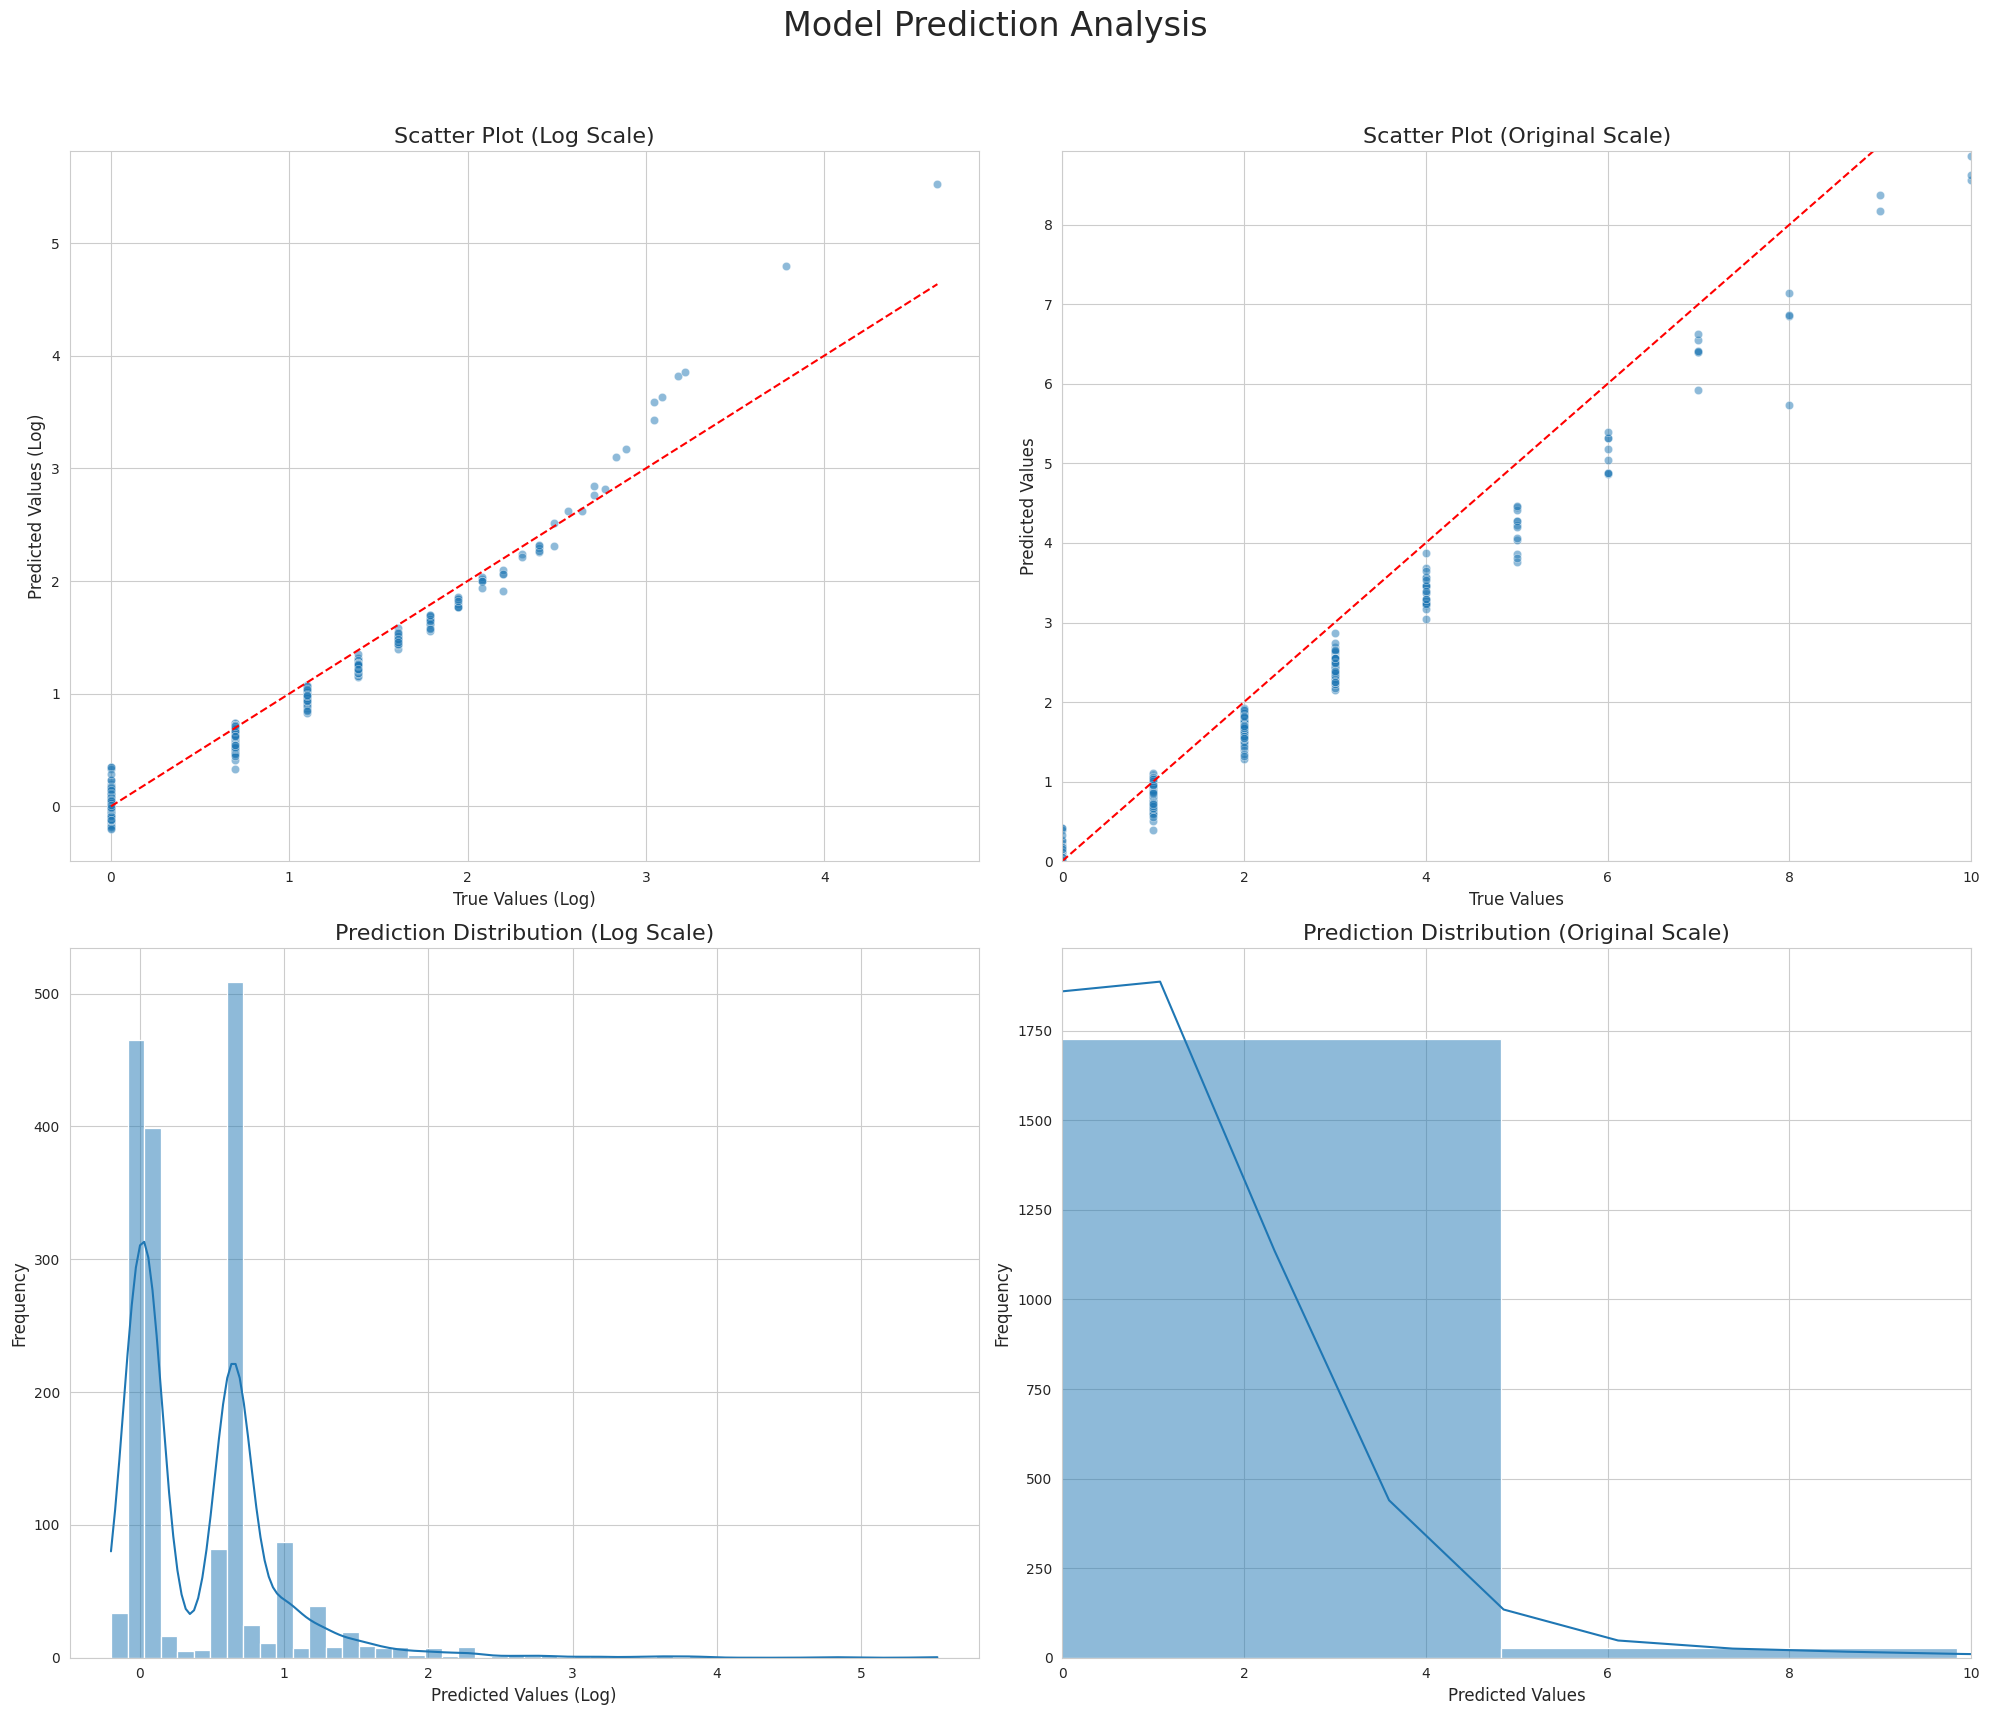

In [63]:
# attention_type 종류: co-attention, s1_to_s2, s2_to_s1, s1_self_attention, s2_self_attention
if __name__ == "__main__":
    CSV_FILE_PATH = "/content/drive/MyDrive/review_helpfulness/PADA/embedded_files/raw_data/coursera.csv"
    try:
        model, embedder, scaler = main_training_pipeline(
            csv_path=CSV_FILE_PATH,
            text_column="Review_Text",
            target_column="Helpfulness",
            feature_columns=['Average_Rating', 'Helpfulness', 'Num_of_Reviews', 'Num_of_Enrolled',
       'Num_of_top_instructor_courses', 'Num_of_top_instructor_learners',
                            'Text_Length', 'Time_Lapsed', 'Deviation_Of_Star_Ratings',
                            'Flesch_Reading_Ease', 'new_depth', 'Breadth', 'Valence', 'Arousal'],
            batch_size=64,
            epochs=10,
            learning_rate=5e-5,
            embedding_cache_size=10000,
            attention_type='co-attention'
        )
    except FileNotFoundError:
        print("\n" + "="*60)
        print(f"오류: '{CSV_FILE_PATH}' 파일을 찾을 수 없습니다.")
        print("실행 블록의 CSV_FILE_PATH 변수를 실제 파일 경로로 수정해주세요.")
        print("="*60)